In [1]:
import os
import pandas as pd
import numpy as np
import re

In [2]:
if os.path.exists('lianjia_data_final.csv'):
    print('存在')
else:
    print('不存在')

存在


In [3]:
shuju=pd.read_csv('lianjia_data_final.csv',encoding='utf-8')

In [4]:
shuju.head()

,标题,价格,区域,链接,抓取时间
0,整租·北京壹号院 5房间 南/北,126000 元/月,朝阳-农展馆-北京壹号院/ 287.01㎡ /南 北 / 5房间1卫 / 低楼层 （9层）,NaN,2026-01-04 19:09:17.063489
1,整租·翠成馨园D区 2室2厅 南,6100 元/月,朝阳-垡头-翠成馨园D区/ 99.21㎡ /南 / 2室2厅1卫 / 中楼层 （28层）,NaN,2026-01-04 19:09:17.576794
2,整租·丽宫 6室3厅 复式 东/南/西/北,109970 元/月,顺义-中央别墅区-丽宫/ 685.60㎡ /东 南 西 北 / 6室3厅6卫 / 地下室 （3层）,NaN,2026-01-04 19:09:18.093158
3,整租·十里春风 3室1厅 南/北,1670 元/月,通州-通州其它-十里春风/ 87.98㎡ /南 北 / 3室1厅1卫 / 中楼层 （22层）,NaN,2026-01-04 19:09:18.605364
4,整租·和平街八区 2室1厅 东/南/西,6300 元/月,朝阳-和平里-和平街八区/ 56.80㎡ /东 南 西 / 2室1厅1卫 / 低楼层 （6层）,NaN,2026-01-04 19:09:19.123590


In [5]:
shuju['区域'] = (
    shuju['区域'].astype(str)  # 保证是字符串
         .str.replace(r'^\s*精选[\/／·\-\s]*', '', regex=True)  # 去掉前导精选及紧随的分隔符/空格
         .str.strip()  # 去掉首尾空白
)

In [6]:
shuju.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   标题      993 non-null    object
 1   价格      993 non-null    object
 2   区域      993 non-null    object
 3   链接      1 non-null      object
 4   抓取时间    993 non-null    object
dtypes: object(5)
memory usage: 38.9+ KB


In [7]:
shuju['链接'] = shuju['链接'].fillna('')

In [8]:
temp_split = shuju['区域'].str.split('-', expand=True)
shuju['行政区'] = temp_split[0]
shuju['片区/商区'] = temp_split[1]
shuju['小区'] = temp_split[2].str.split('/').str[0]

In [9]:
details = shuju['区域'].str.split('/', expand=True)

shuju['面积'] = details[1]
shuju['朝向'] = details[2]
shuju['房间'] = details[3]

In [10]:
shuju['高低位'] = details[4].str.extract(r'(地下室|低楼层|中楼层|高楼层)')[0].fillna("未知")

In [11]:
shuju['层数'] = details[4].str.extract(r'（(\d+)层）')[0].fillna("未知")

In [12]:
shuju['价格_数值'] = shuju['价格'].str.replace('元/月', '').str.replace(',', '').astype('int64')
shuju['价格_单位'] = '元/月'

In [13]:
shuju['面积_m²'] = shuju['面积'].astype(str).str.replace('\u00A0', ' ', regex=False).str.replace('\u3000', ' ', regex=False)
shuju['面积_m²'] = shuju['面积_m²'].str.replace(r'(㎡|m²|m2|m\^2|平米|平)', '', regex=True)
shuju['面积_m²'] = shuju['面积_m²'].str.strip().str.replace(r'\s+', ' ', regex=True)
shuju['面积_m²'] = shuju['面积_m²'].str.split().str[0]
shuju['面积_m²'] = pd.to_numeric(shuju['面积_m²'], errors='coerce')  # 转为数值，无法解析的变 NaN

In [14]:
mask_basement = shuju['房间'].astype(str).str.contains(r'地下室', na=False)

In [15]:
display(shuju.loc[mask_basement].head(20))

,标题,价格,区域,链接,抓取时间,行政区,片区/商区,小区,面积,朝向,房间,高低位,层数,价格_数值,价格_单位,面积_m²
215,整租·芭蕾雨悦都北区 车库,500 元/月,房山-长阳-芭蕾雨悦都北区/ 30.60㎡ // 地下室,,2026-01-04 19:13:01.487779,房山,长阳,芭蕾雨悦都北区,30.60㎡,,地下室,未知,未知,500,元/月,30.60
631,整租·丽景长安二期 车库,500 元/月,门头沟-冯村-丽景长安二期/ 32.68㎡ // 地下室,,2026-01-04 19:24:08.187561,门头沟,冯村,丽景长安二期,32.68㎡,,地下室,未知,未知,500,元/月,32.68


In [16]:
shuju.drop(index=shuju[mask_basement].index, inplace=True)

In [17]:
shuju['每平米的价格']=shuju['价格_数值']/shuju['面积_m²']
shuju['每平米的价格'] = shuju['每平米的价格'].round(2)

In [18]:
shuju.head()

,标题,价格,区域,链接,抓取时间,行政区,片区/商区,小区,面积,朝向,房间,高低位,层数,价格_数值,价格_单位,面积_m²,每平米的价格
0,整租·北京壹号院 5房间 南/北,126000 元/月,朝阳-农展馆-北京壹号院/ 287.01㎡ /南 北 / 5房间1卫 / 低楼层 （9层）,,2026-01-04 19:09:17.063489,朝阳,农展馆,北京壹号院,287.01㎡,南 北,5房间1卫,低楼层,9,126000,元/月,287.01,439.01
1,整租·翠成馨园D区 2室2厅 南,6100 元/月,朝阳-垡头-翠成馨园D区/ 99.21㎡ /南 / 2室2厅1卫 / 中楼层 （28层）,,2026-01-04 19:09:17.576794,朝阳,垡头,翠成馨园D区,99.21㎡,南,2室2厅1卫,中楼层,28,6100,元/月,99.21,61.49
2,整租·丽宫 6室3厅 复式 东/南/西/北,109970 元/月,顺义-中央别墅区-丽宫/ 685.60㎡ /东 南 西 北 / 6室3厅6卫 / 地下室 （3层）,,2026-01-04 19:09:18.093158,顺义,中央别墅区,丽宫,685.60㎡,东 南 西 北,6室3厅6卫,地下室,3,109970,元/月,685.60,160.40
3,整租·十里春风 3室1厅 南/北,1670 元/月,通州-通州其它-十里春风/ 87.98㎡ /南 北 / 3室1厅1卫 / 中楼层 （22层）,,2026-01-04 19:09:18.605364,通州,通州其它,十里春风,87.98㎡,南 北,3室1厅1卫,中楼层,22,1670,元/月,87.98,18.98
4,整租·和平街八区 2室1厅 东/南/西,6300 元/月,朝阳-和平里-和平街八区/ 56.80㎡ /东 南 西 / 2室1厅1卫 / 低楼层 （6层）,,2026-01-04 19:09:19.123590,朝阳,和平里,和平街八区,56.80㎡,东 南 西,2室1厅1卫,低楼层,6,6300,元/月,56.80,110.92


In [19]:
shuju.info()

<class 'pandas.core.frame.DataFrame'>
Index: 991 entries, 0 to 992
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   标题      991 non-null    object 
 1   价格      991 non-null    object 
 2   区域      991 non-null    object 
 3   链接      991 non-null    object 
 4   抓取时间    991 non-null    object 
 5   行政区     991 non-null    object 
 6   片区/商区   991 non-null    object 
 7   小区      991 non-null    object 
 8   面积      991 non-null    object 
 9   朝向      991 non-null    object 
 10  房间      991 non-null    object 
 11  高低位     991 non-null    object 
 12  层数      991 non-null    object 
 13  价格_数值   991 non-null    int64  
 14  价格_单位   991 non-null    object 
 15  面积_m²   991 non-null    float64
 16  每平米的价格  991 non-null    float64
dtypes: float64(2), int64(1), object(14)
memory usage: 139.4+ KB


In [20]:
print(shuju[['价格_数值','面积_m²','层数','抓取时间']].dtypes)
print(shuju[['价格_数值','面积_m²','层数']].isna().sum())

价格_数值      int64
面积_m²    float64
层数        object
抓取时间      object
dtype: object
价格_数值    0
面积_m²    0
层数       0
dtype: int64


In [21]:
shuju.to_csv('北京租房市场捡漏项目.csv')

In [22]:
shuju_sorted = shuju.sort_values(by='价格_数值', ascending=False).reset_index(drop=True)
shuju_sorted.head(30)

,标题,价格,区域,链接,抓取时间,行政区,片区/商区,小区,面积,朝向,房间,高低位,层数,价格_数值,价格_单位,面积_m²,每平米的价格
0,整租·优山美地B区 5室3厅 复式 南/北,139000 元/月,顺义-中央别墅区-优山美地B区/ 790.00㎡ /南 北 / 5室3厅6卫 / 低楼层 （2层）,,2026-01-04 19:15:06.360958,顺义,中央别墅区,优山美地B区,790.00㎡,南 北,5室3厅6卫,低楼层,2,139000,元/月,790.00,175.95
1,整租·北京壹号院 5房间 南/北,126000 元/月,朝阳-农展馆-北京壹号院/ 287.01㎡ /南 北 / 5房间1卫 / 低楼层 （9层）,,2026-01-04 19:09:17.063489,朝阳,农展馆,北京壹号院,287.01㎡,南 北,5房间1卫,低楼层,9,126000,元/月,287.01,439.01
2,整租·银湖别墅 5室1厅 南/北,120000 元/月,朝阳-大山子-银湖别墅/ 243.00㎡ /南 北 / 5室1厅3卫 / 地下室 （2层）,,2026-01-04 19:24:24.286457,朝阳,大山子,银湖别墅,243.00㎡,南 北,5室1厅3卫,地下室,2,120000,元/月,243.00,493.83
3,整租·丽宫 6室3厅 复式 东/南/西/北,109970 元/月,顺义-中央别墅区-丽宫/ 685.60㎡ /东 南 西 北 / 6室3厅6卫 / 地下室 （3层）,,2026-01-04 19:09:18.093158,顺义,中央别墅区,丽宫,685.60㎡,东 南 西 北,6室3厅6卫,地下室,3,109970,元/月,685.60,160.40
4,整租·丛林庄别墅 10室7厅 南/北,100000 元/月,通州-潞苑-丛林庄别墅/ 445.70㎡ /南 北 / 10室7厅9卫 / 低楼层 （3层）,,2026-01-04 19:13:05.040214,通州,潞苑,丛林庄别墅,445.70㎡,南 北,10室7厅9卫,低楼层,3,100000,元/月,445.70,224.37
5,整租·Wehouse 15室3厅 复式 南/北,100000 元/月,海淀-四季青-Wehouse/ 315.29㎡ /南 北 / 15室3厅9卫 / 低楼层 （3层）,,2026-01-04 19:10:24.191171,海淀,四季青,Wehouse,315.29㎡,南 北,15室3厅9卫,低楼层,3,100000,元/月,315.29,317.17
6,整租·亲爱的villa 5室3厅 复式 东/南/西/北,75000 元/月,北京经济技术开发区-亦庄-亲爱的villa/ 429.82㎡ /东 南 西 北 / 5室3厅...,https://bj.lianjia.com/zufang/BJ19072717271135...,2026-01-04 19:10:32.388205,北京经济技术开发区,亦庄,亲爱的villa,429.82㎡,东 南 西 北,5室3厅4卫,低楼层,2,75000,元/月,429.82,174.49
7,整租·大湖山庄 6室2厅 复式 南/北,74700 元/月,朝阳-中央别墅区-大湖山庄/ 500.00㎡ /南 北 / 6室2厅5卫 / 低楼层 （2层）,,2026-01-04 19:14:28.847783,朝阳,中央别墅区,大湖山庄,500.00㎡,南 北,6室2厅5卫,低楼层,2,74700,元/月,500.00,149.40
8,整租·公园大道 3室2厅 南/北,72000 元/月,朝阳-朝阳公园-公园大道/ 350.00㎡ /南 北 / 3室2厅3卫 / 高楼层 （16层）,,2026-01-04 19:15:00.709072,朝阳,朝阳公园,公园大道,350.00㎡,南 北,3室2厅3卫,高楼层,16,72000,元/月,350.00,205.71
9,整租·紫玉山庄 5室2厅 复式 东/南/西/北,70000 元/月,朝阳-亚运村-紫玉山庄/ 343.63㎡ /东 南 西 北 / 5室2厅5卫 / 低楼层 （3层）,,2026-01-04 19:10:44.034960,朝阳,亚运村,紫玉山庄,343.63㎡,东 南 西 北,5室2厅5卫,低楼层,3,70000,元/月,343.63,203.71


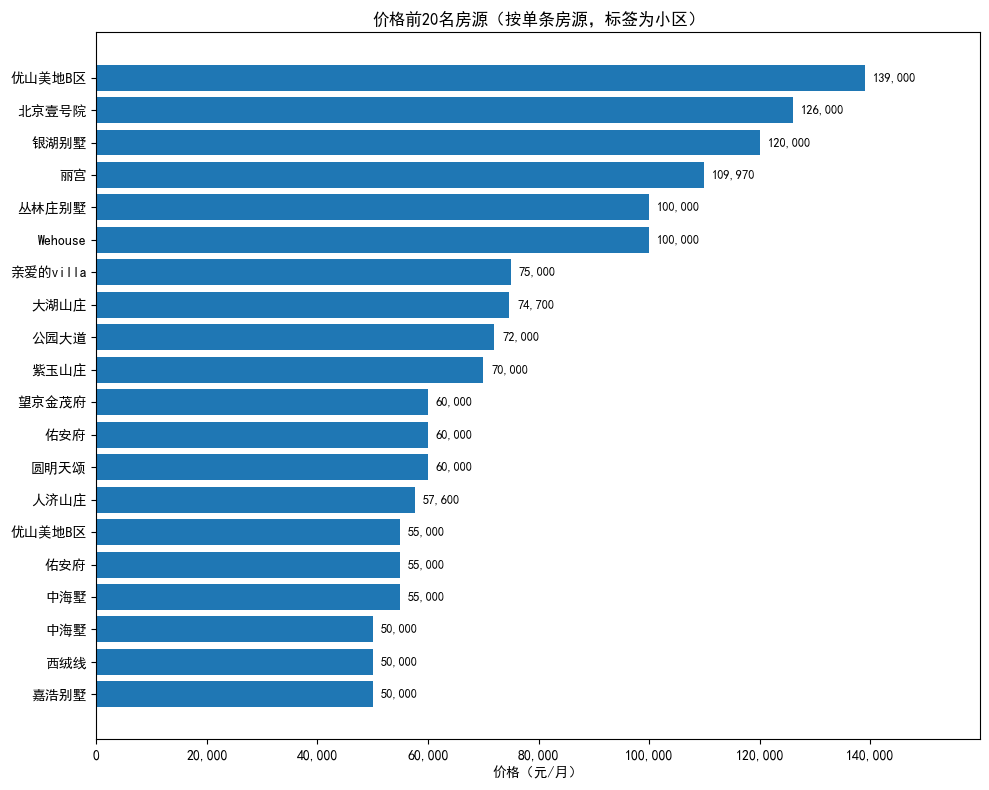

已保存图片： top20_price_by_xiaoqu_fixed.png


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib as mpl

# 可选：尝试设置中文字体（Windows 常用 SimHei / Microsoft YaHei）
# 如果你的系统没有 SimHei，请把 'SimHei' 改成可用中文字体名，或安装 SimHei
mpl.rcParams['font.sans-serif'] = ['SimHei']     # 或 ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False       # 解决负号 '-' 显示为方块的问题

# 确保数值列存在并去掉缺失
shuju['价格_数值'] = pd.to_numeric(shuju['价格_数值'], errors='coerce')
data = shuju.dropna(subset=['价格_数值', '小区']).copy()

# 取前20并准备标签（小区为标签）
top20 = data.sort_values(by='价格_数值', ascending=False).head(20).reset_index(drop=True)
labels = top20['小区'].astype(str).str.slice(0,30)   # 截断避免太长
values = top20['价格_数值'].astype(float)

# 倒序显示最高价在顶部
labels_rev = labels[::-1].tolist()
values_rev = values[::-1].tolist()

# 绘图
fig, ax = plt.subplots(figsize=(10,8))
y_pos = np.arange(len(labels_rev))
bars = ax.barh(y_pos, values_rev, color='tab:blue')

# 标签与标题（中文现在能正常显示）
ax.set_yticks(y_pos)
ax.set_yticklabels(labels_rev, fontsize=10)
ax.set_xlabel('价格（元/月）')
ax.set_title('价格前20名房源（按单条房源，标签为小区）')

# 格式化 x 轴为千分位
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

# 确保右侧有足够空间以显示注释：把 x 轴上限稍微扩大一点
xmax = max(values_rev) if len(values_rev)>0 else 1
ax.set_xlim(0, xmax * 1.15)   # 15% 额外空间

# 在条末尾显示数值，位置用相对于 xmax 的小偏移，避免被遮挡
for i, v in enumerate(values_rev):
    ax.text(v + xmax*0.01, i, f"{v:,.0f}", va='center', fontsize=9)

# 如果 y 轴标签很长，可以增加左边距
plt.subplots_adjust(left=0.30, right=0.95, top=0.92, bottom=0.05)

# 保存时使用 bbox_inches='tight' 防止被裁剪
plt.tight_layout()
plt.savefig('top20_price_by_xiaoqu_fixed.png', bbox_inches='tight', dpi=150)
plt.show()
print("已保存图片： top20_price_by_xiaoqu_fixed.png")